In [1]:
import pandas as pd

# Define the file path
file_path = '../logs/faketime_pause.log'

# Read the log file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the log data
data = []
for line in lines:
    if not line.startswith('1'):
        print(f'Skipping line: {line}')
        continue
    parts = line.strip().split(',')
    if len(parts) == 2:
        faked_ts, real_elapsed = parts
        data.append([faked_ts, real_elapsed])

# Create a DataFrame
df = pd.DataFrame(data, columns=['fake', 'real'])

# Display the DataFrame
df.head()

Skipping line: read from config: address = tcp://127.0.0.1:10101, topic = service_discovery/report

Skipping line: Message with delivery token 1 delivered

Skipping line: Process PID: 2256448. Waiting for signal 40 to continue...

Skipping line: Debugger attached. Resume execution...

Skipping line: ddb connector initialized. meta = { pid = 2256448, comm_ip = 2130706433, ipv4_str =127.0.0.1 }



,fake,real
0,1732103867575819,610
1,1732103867575896,684
2,1732103867575970,759
3,1732103867576045,833
4,1732103867576119,908


In [2]:
# normalize the data by substraction the first value
df['fake'] = df['fake'].astype(int) - df['fake'].astype(int).iloc[0]
df['real'] = df['real'].astype(int) - df['real'].astype(int).iloc[0]
df.head()

,fake,real
0,0,0
1,77,74
2,151,149
3,226,223
4,300,298


In [ ]:
# find the index where the two consecutive values at real rows are larger than 5000
idx = df[(df['real'].diff() > 5000)].index
idx 

Index([ 26939,  54116,  81265, 108445, 135657, 162851, 190073, 217298, 244512,
       271705, 298893, 326068, 353273, 380448],
      dtype='int64')

In [23]:
suspend_pt = idx - 1
suspend_pt

Index([ 26938,  54115,  81264, 108444, 135656, 162850, 190072, 217297, 244511,
       271704, 298892, 326067, 353272, 380447],
      dtype='int64')

In [24]:
# get all rows at the index
df.loc[suspend_pt]

,fake,real
26938,2012633,2012667
54115,4047749,5047136
81264,6081190,8080761
108444,8115755,11115504
135656,10151433,14151386
162850,12187140,17187179
190072,14223726,20223886
217297,16260334,23260817
244511,18296270,26297097
271704,20330820,29331929


In [40]:
[ int(n/1000000) for n in range(df['real'].min(), df['real'].max(), 1000000)]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43]

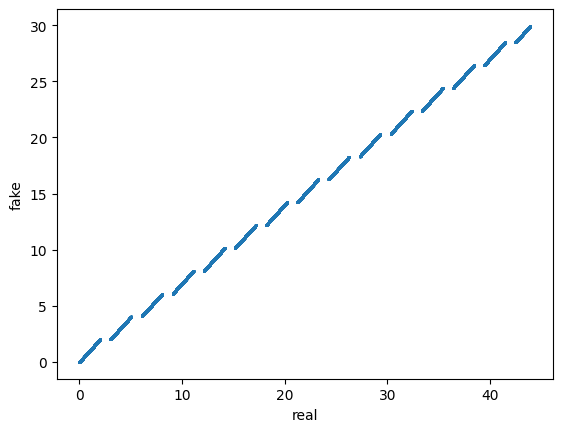

In [45]:
# draw a scatter plot of the df data where the x-axis is the fake column and y-axis is a constant value
# df['constant'] = 1  # Add a constant column for y-axis

df_scaled = df.copy()
df_scaled['real'] = df_scaled['real'] / 1000000
df_scaled['fake'] = df_scaled['fake'] / 1000000

import matplotlib.pyplot as plt

ax = df_scaled.plot.scatter(x='real', y='fake', s=0.1)


# ax.set_xticklabels([ int(n/1000000) for n in range(df['real'].min(), df['real'].max(), 1000000)])
# ax.set_yticklabels([ int(n/1000000) for n in range(df['fake'].min(), df['fake'].max(), 1000000)])
plt.show()

In [54]:
num_points = 10000

extracted_data = pd.DataFrame()

for i in idx:
    start_idx = max(i - num_points // 2, 0)
    end_idx = min(i + num_points // 2, len(df))
    extracted_data = pd.concat([extracted_data, df.iloc[start_idx:end_idx]])
    break

extracted_data.head()

,fake,real,constant
21939,1639107,1639134,1
21940,1639182,1639209,1
21941,1639256,1639283,1
21942,1639331,1639358,1
21943,1639405,1639432,1


In [57]:
df.iloc[idx[0] - 1], df.iloc[idx[0]], df.iloc[idx[0] + 1]

(fake        2012633
 real        2012667
 constant          1
 Name: 26938, dtype: int64,
 fake        2016445
 real        3015801
 constant          1
 Name: 26939, dtype: int64,
 fake        2016546
 real        3015897
 constant          1
 Name: 26940, dtype: int64)

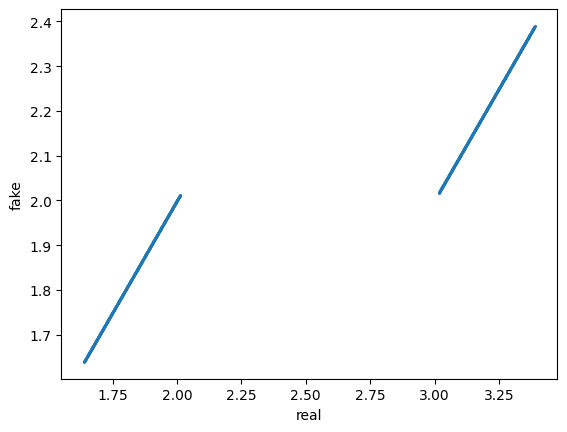

In [55]:
# draw a scatter plot of the df data where the x-axis is the fake column and y-axis is a constant value
# df['constant'] = 1  # Add a constant column for y-axis

extracted_data_scaled = extracted_data.copy()
extracted_data_scaled['real'] = extracted_data_scaled['real'] / 1000000
extracted_data_scaled['fake'] = extracted_data_scaled['fake'] / 1000000

import matplotlib.pyplot as plt

ax = extracted_data_scaled.plot.scatter(x='real', y='fake', s=0.1)


# ax.set_xticklabels([ int(n/1000000) for n in range(df['real'].min(), df['real'].max(), 1000000)])
# ax.set_yticklabels([ int(n/1000000) for n in range(df['fake'].min(), df['fake'].max(), 1000000)])
plt.show()